In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
sys.path.insert(0, module_path)
import warnings
warnings.simplefilter("ignore")

# Download Wroclaw

In [2]:
# change if needed

CITY = "Wrocław" 
COUNTRY = "Poland"

area_name = f"{CITY}, {COUNTRY}"
area_name

'Wrocław, Poland'

In [3]:
area = None
from srai.regionalizers import geocode_to_region_gdf
# YOUR CODE HERE
area = geocode_to_region_gdf(area_name)

area.explore(height=500)

# Load features

In [4]:
import pandas as pd

df = pd.read_excel('../data/all-restaurants-all-data-cleanup.xlsx', header=1)

redundant_columns = ['city',
 'place_type',
 'business_status',
 'formatted_address',
 'icon',
 'icon_background_color',
 'icon_mask_base_uri',
 'name',
 'n_photos',
 'plus_code_compound',
 'plus_code_global',
 'price_level',
 'rating',
 'types',
 'user_ratings_total',
 'permanently_closed',
 'address', 
#  'categories/0', 
#  'categories/1', 
#  'categories/2',
# 'categories/3', 
# 'categories/4', 
# 'categories/5', 
# 'categories/6',
# 'categories/7', 
# 'categories/8', 
# 'categories/9', 
# 'categories/10',
'categoryName', 
'cid', 
'description',
'neighborhood',
'plusCode',
'title',
 ]

redundant_columns = redundant_columns

In [5]:
cats = [ 'categories/0', 
 'categories/1', 
 'categories/2',
'categories/3', 
'categories/4', 
'categories/5', 
'categories/6',
'categories/7', 
'categories/8', 
'categories/9', 
'categories/10',]

In [6]:
import numpy as np
df['cat_list'] = list([c for c in v if c != ''] for v in df[cats].fillna('').values)

In [7]:
cats_df = pd.get_dummies(df['cat_list'].explode(), prefix='cat_').groupby(level=0).sum().astype(bool)

In [8]:
df = df.drop(columns = cats + ['cat_list'], errors='ignore')

In [9]:
df = pd.concat([df.fillna(False), cats_df], axis=1)

In [10]:
df['price'][~df['price'].isin([False, '$', '$$', '$$$'])] = '$$$'

In [11]:
for c in df.drop(columns=redundant_columns, errors='ignore').columns:
    print(df[c].value_counts())
    print('============')

Dostawa
False    375
True     278
Name: count, dtype: int64
Dostawa bez kontaktu
False    507
True     146
Name: count, dtype: int64
Na miejscu
True     630
False     23
Name: count, dtype: int64
Na wynos
True     581
False     72
Name: count, dtype: int64
Odbiór na zewnątrz
False    470
True     183
Name: count, dtype: int64
Ogródek
False    328
True     325
Name: count, dtype: int64
Dobre miejsce na przyjęcia urodzinowe dla dzieci
False    622
True      31
Name: count, dtype: int64
Krzesełka do karmienia
False    402
True     251
Name: count, dtype: int64
Menu dla dzieci
False    380
True     273
Name: count, dtype: int64
Odpowiednie dla dzieci
True     394
False    259
Name: count, dtype: int64
Dla całej rodziny
False    380
True     273
Name: count, dtype: int64
Miejsce przyjazne dla osób transpłciowych
False    587
True      66
Name: count, dtype: int64
Przyjazne dla osób LGBTQ+
False    568
True      85
Name: count, dtype: int64
Przytulne
True     358
False    295
Name: count, dt

In [12]:
feature_df = df.drop(columns=redundant_columns, errors='ignore').set_index('placeId')

In [13]:
feature_df['count'] = 1

In [14]:
# import shapely

# geom_list = []
# for i in range(len(feature_df)):
#     row = feature_df.iloc[i][['location/lat', 'location/lng']].values
#     geom_list.append(shapely.Point(*row))

# feature_df = pd.concat([feature_df.reset_index(), pd.DataFrame(geom_list, columns=['geometry']).reset_index()], axis=1).set_index('placeId')

# feature_df = feature_df.drop(columns=['location/lat', 'location/lng'])

In [15]:
import geopandas
features = geopandas.GeoDataFrame(feature_df, 
                             geometry=geopandas.points_from_xy(df['location/lng'], df['location/lat']), 
                             crs="EPSG:4326")

In [16]:
features.index.names = ['feature_id']

In [17]:
features.index.value_counts().to_frame().sort_values(by='count', ascending=False).head(5)

count
feature_id                        
ChIJeccWamjBD0cRr8l49FmA3sI      2
ChIJ40euBM_DD0cREwUBIQQ4aCE      1
ChIJX-tlUcnBD0cRrllmH2luBiA      1
ChIJe3h0e6HBD0cRkKrxyhkma4M      1
ChIJcfwiMibBD0cRCxlbmSJiBKY      1

In [18]:
features = features.drop(index='ChIJeccWamjBD0cRr8l49FmA3sI')

In [19]:
features.explore()

# Load admin regions

In [20]:
regions_admin = None
### BEGIN SOLUTION
from srai.regionalizers import AdministrativeBoundaryRegionalizer
from srai.plotting import plot_regions
regions_admin = AdministrativeBoundaryRegionalizer(9).transform(area)
plot_regions(regions_admin)

Loading boundaries: 48: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


# Make hex regions

In [21]:
regions_hex = None
### BEGIN SOLUTION
from srai.regionalizers import H3Regionalizer
from srai.plotting import plot_regions
regions_hex = H3Regionalizer(8).transform(area)
plot_regions(regions_hex)

In [22]:
regions_hex.head(5)

geometry
region_id                                                         
881e204087fffff  POLYGON ((17.02740 51.09661, 17.02498 51.09233...
881e204761fffff  POLYGON ((17.05909 51.14046, 17.05667 51.13618...
881e2051b1fffff  POLYGON ((16.84758 51.16935, 16.84517 51.16507...
881e204181fffff  POLYGON ((16.95532 51.06666, 16.95291 51.06237...
881e20423dfffff  POLYGON ((16.92318 51.15656, 16.92077 51.15228...

# Admin embeds

In [23]:
def join_float_values(embed_df, col_name):

    def cast_to_float(a):
        try:
            return float(a)
        except ValueError:
            return 0.


    num_col_names = get_column_divisions(embed_df, col_name)

    num_col_float = np.array([cast_to_float( n[ len(col_name) + 1 :] ) for n in num_col_names])

    num_col_values = embed_df[num_col_names].values

    avg_vals = np.multiply(num_col_values, num_col_float).sum(axis=1) / num_col_values.sum(axis=1)

    embed_df[col_name] = avg_vals

    embed_df = delete_column(embed_df, col_name)

    return embed_df

def delete_column(embed_df, col_name):

    num_col_names = get_column_divisions(embed_df, col_name)

    embed_df = embed_df.drop(columns=num_col_names)

    return embed_df

def get_column_divisions(embed_df, col_name):
    return [c for c in embed_df.columns if c[: len(col_name) + 1  ] == col_name+'_']

def calculate_embed_mean(embed_df, exception_columns):

    avg_columns = [c for c in embed_df.columns if c not in exception_columns]
    embed_df = embed_df[avg_columns].div(embed_df['count'], axis=0)
    return embed_df

In [24]:
joint_admin = None
### BEGIN SOLUTION
from srai.joiners import IntersectionJoiner
joint_admin = IntersectionJoiner().transform(regions_admin, features)
### END SOLUTION
joint_admin.head(3)

Empty DataFrame
Columns: []
Index: [(Osiedle Ołtaszyn, ChIJPSjkff3DD0cRddZY2fpqI14), (Osiedle Ołtaszyn, ChIJ9XD1d6fDD0cRAHHtHWy0WEw), (Osiedle Ołtaszyn, ChIJbzhodqfDD0cRykRGbY060tk)]

In [25]:
embeddings_admin = None
### BEGIN SOLUTION
from srai.embedders import CountEmbedder
embedder = CountEmbedder()
embeddings_admin = embedder.transform(regions_admin, features, joint_admin)
### END SOLUTION
embeddings_admin.head(3)

Dostawa  Dostawa bez kontaktu  Na miejscu  Na wynos  \
region_id                                                                       
Osiedle Ołtaszyn                2                     0           6         6   
Osiedle Wojszyce                1                     1           2         2   
Osiedle Krzyki-Partynice       19                     8          42        41   

                          Odbiór na zewnątrz  Ogródek  \
region_id                                               
Osiedle Ołtaszyn                           1        4   
Osiedle Wojszyce                           0        2   
Osiedle Krzyki-Partynice                  13       26   

                          Dobre miejsce na przyjęcia urodzinowe dla dzieci  \
region_id                                                                    
Osiedle Ołtaszyn                                                         0   
Osiedle Wojszyce                                                         0   
Osiedle Krzyki-Partynice                                                 1   

                          Krzesełka do karmienia  Menu dla dzieci  \
region_id                                                           
Osiedle Ołtaszyn                               4                2   
Osiedle Wojszyce                               0                2   
Osiedle Krzyki-Partynice                      22               21   

                          Odpowiednie dla dzieci  ...  totalScore_4.1  \
region_id                                         ...                   
Osiedle Ołtaszyn                               3  ...               1   
Osiedle Wojszyce                               2  ...               0   
Osiedle Krzyki-Partynice                      31  ...               3   

                          totalScore_4.2  totalScore_4.3  totalScore_4.4  \
region_id                                                                  
Osiedle Ołtaszyn                       0               1               1   
Osiedle Wojszyce                       1               0               1   
Osiedle Krzyki-Partynice               3               5               4   

                          totalScore_4.5  totalScore_4.6  totalScore_4.7  \
region_id                                                                  
Osiedle Ołtaszyn                       0               1               0   
Osiedle Wojszyce                       0               0               0   
Osiedle Krzyki-Partynice               6               2               6   

                          totalScore_4.8  totalScore_4.9  totalScore_5.0  
region_id                                                                 
Osiedle Ołtaszyn                       0               1               0  
Osiedle Wojszyce                       0               0               0  
Osiedle Krzyki-Partynice               3               0               1  

[3 rows x 1544 columns]

In [26]:
data_column = None
### BEGIN SOLUTION
from srai.plotting import plot_numeric_data
data_column = "price_$$$"
plot_numeric_data(regions_admin, data_column, embeddings_admin)
### END SOLUTION

# Hex embeds

In [27]:
joint_hex = None
### BEGIN SOLUTION
from srai.joiners import IntersectionJoiner
joint_hex = IntersectionJoiner().transform(regions_hex, features)
### END SOLUTION
joint_hex.head(3)

Empty DataFrame
Columns: []
Index: [(881e204087fffff, ChIJ_7rXztnDD0cRXIWV1KfjWi8), (881e204087fffff, ChIJff9m9GfCD0cRIGsCitRjjdc), (881e204087fffff, ChIJUaTFHcjCD0cRAE3SFNCJak8)]

In [28]:
hex_with_stuff = joint_hex.reset_index()['region_id'].unique()
regions_hex_filtered = regions_hex[regions_hex.index.isin(hex_with_stuff)]

In [30]:
embeddings_hex = None
### BEGIN SOLUTION
from srai.embedders import CountEmbedder
embedder = CountEmbedder()
embeddings_hex = embedder.transform(regions_hex_filtered, features, joint_hex)
### END SOLUTION
embeddings_hex.head(3)

Dostawa  Dostawa bez kontaktu  Na miejscu  Na wynos  \
region_id                                                              
881e204087fffff        3                     1           7         7   
881e204761fffff        2                     1           3         3   
881e20423dfffff        2                     1           3         3   

                 Odbiór na zewnątrz  Ogródek  \
region_id                                      
881e204087fffff                   0        1   
881e204761fffff                   2        3   
881e20423dfffff                   1        2   

                 Dobre miejsce na przyjęcia urodzinowe dla dzieci  \
region_id                                                           
881e204087fffff                                                 0   
881e204761fffff                                                 0   
881e20423dfffff                                                 0   

                 Krzesełka do karmienia  Menu dla dzieci  \
region_id                                                  
881e204087fffff                       1                2   
881e204761fffff                       3                3   
881e20423dfffff                       1                1   

                 Odpowiednie dla dzieci  ...  totalScore_4.1  totalScore_4.2  \
region_id                                ...                                   
881e204087fffff                       4  ...               0               1   
881e204761fffff                       3  ...               0               0   
881e20423dfffff                       2  ...               0               0   

                 totalScore_4.3  totalScore_4.4  totalScore_4.5  \
region_id                                                         
881e204087fffff               0               1               0   
881e204761fffff               0               0               0   
881e20423dfffff               2               0               0   

                 totalScore_4.6  totalScore_4.7  totalScore_4.8  \
region_id                                                         
881e204087fffff               0               0               0   
881e204761fffff               0               2               0   
881e20423dfffff               0               1               0   

                 totalScore_4.9  totalScore_5.0  
region_id                                        
881e204087fffff               0               0  
881e204761fffff               0               0  
881e20423dfffff               0               0  

[3 rows x 1544 columns]

In [31]:
embeddings_hex = join_float_values(embed_df=embeddings_hex, col_name='totalScore')
embeddings_hex = delete_column(embeddings_hex, col_name='location/lng')
embeddings_hex = delete_column(embeddings_hex, col_name='location/lat')
non_informative_columns = embeddings_hex.columns[embeddings_hex.sum() < 2]
embeddings_hex = embeddings_hex.drop(columns=non_informative_columns)

In [32]:
embeddings_hex_mean = calculate_embed_mean(embed_df=embeddings_hex, exception_columns=['totalScore'])

In [33]:
data_column = None
### BEGIN SOLUTION
from srai.plotting import plot_numeric_data
data_column = "Swobodna atmosfera"
plot_numeric_data(regions_hex, data_column, embeddings_hex)
### END SOLUTION

# Embeds tinkering

In [34]:
serio_embeds = embeddings_hex_mean.drop(columns=['count']).copy()
serio_embeds_values_raw = serio_embeds.values

In [35]:
from sklearn.preprocessing import StandardScaler

serio_embeds_values = StandardScaler().fit_transform(serio_embeds_values_raw)

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_embed = pca.fit_transform(serio_embeds_values)

49


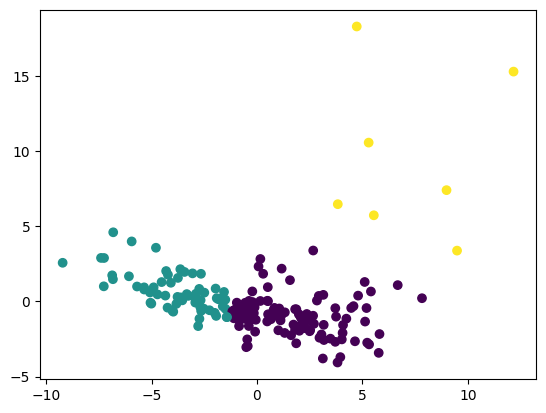

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

rand_state = random.randint(0, 100)
kmeans = KMeans(n_clusters=3, random_state=32, n_init="auto").fit(pca_embed)

print(rand_state)
plt.scatter(x=pca_embed[:,0], y=pca_embed[:,1], c = kmeans.labels_)

In [38]:

plot_embeds = serio_embeds.copy()
plot_embeds['labels'] = kmeans.labels_
plot_numeric_data(regions_hex, 'labels', plot_embeds)

In [39]:
labels_embed = plot_embeds.groupby(by='labels').mean()

columns_rank = {}

for c in labels_embed.columns:
    columns_rank[c] = np.std(labels_embed[c])

top_col = sorted(columns_rank.items(), key = lambda x : x[1], reverse=True) [:20]

labels_embed[[c for c,_ in top_col]]

Toaleta  Przytulne  Na miejscu  Na wynos   Kolacja      Piwo  \
labels                                                                  
0       0.636566   0.362375    0.973753  0.908205  0.813799  0.291116   
1       0.957068   0.860535    0.997696  0.909548  0.972878  0.807937   
2       0.214286   0.142857    0.357143  0.285714  0.285714  0.142857   

        Swobodna atmosfera     Obiad  price_$$  cat__Hotel   Alkohol  \
labels                                                                 
0                 0.910370  0.881001  0.223396    0.004018  0.392098   
1                 0.993789  0.976915  0.704844    0.000000  0.845404   
2                 0.357143  0.357143  0.071429    0.571429  0.214286   

            Kawa  Możliwa rezerwacja  dania wegetariańskie      Wino  \
labels                                                                 
0       0.622322            0.308165              0.312239  0.190108   
1       0.934284            0.812428              0.708480  0.701749   
2       0.285714            0.214286              0.071429  0.142857   

         Ogródek    Desery  price_$$$  Bezpłatny parking  \
labels                                                     
0       0.384825  0.441634   0.008482           0.363988   
1       0.741604  0.859189   0.030539           0.531349   
2       0.142857  0.285714   0.500000           0.000000   

        Miejsca dla osób na wózkach  
labels                               
0                          0.463386  
1                          0.753107  
2                          0.214286

In [40]:
from sklearn.manifold import TSNE

tsne_embed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(serio_embeds_values)

50


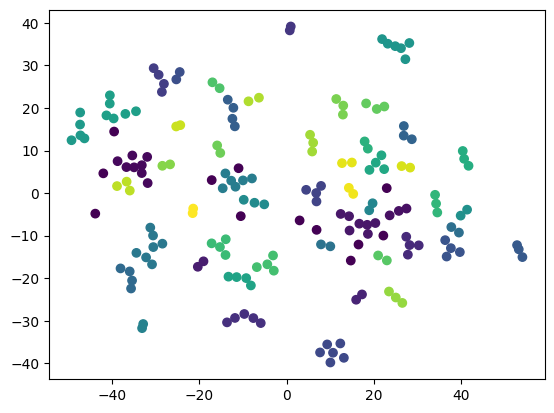

In [41]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import random

rand_state = random.randint(0, 100)
clustering = DBSCAN(eps=3, min_samples=2).fit(tsne_embed)

print(rand_state)
plt.scatter(x=tsne_embed[:,0], y=tsne_embed[:,1], c = clustering.labels_)

In [47]:
plot_embeds = serio_embeds.copy()
plot_embeds['labels'] = clustering.labels_
plot_numeric_data(regions_hex, 'labels', plot_embeds[plot_embeds['labels'] == 12])
# plot_numeric_data(regions_hex, 'labels', plot_embeds)